In [1]:
# Task 2: Implement a multi-class perceptron algorithm

In [ ]:
# 读取训练集和测试集数据，数据路径在上级目录 ../dataset/
import os
import pandas as pd

BASE_DIR = os.getcwd()  # 当前工作目录（notebook运行目录）
DATA_DIR = os.path.abspath(os.path.join(BASE_DIR, "..", "dataset"))

TRAIN_IN_PATH = os.path.join(DATA_DIR, "train_in.csv")
TRAIN_OUT_PATH = os.path.join(DATA_DIR, "train_out.csv")
TEST_IN_PATH = os.path.join(DATA_DIR, "test_in.csv")
TEST_OUT_PATH = os.path.join(DATA_DIR, "test_out.csv")


def load_data():
    X_train = pd.read_csv(TRAIN_IN_PATH, header=None).values
    y_train = pd.read_csv(TRAIN_OUT_PATH, header=None).values.ravel()
    X_test = pd.read_csv(TEST_IN_PATH, header=None).values
    y_test = pd.read_csv(TEST_OUT_PATH, header=None).values.ravel().astype(int)
    assert (
        X_train.shape[1] == 256
    ), f"Expected feature dimension 256, got {X_train.shape[1]}"
    assert (
        y_train.shape[0] == X_train.shape[0]
    ), f"y_train sample size should match X_train, got y_train: {y_train.shape[0]}, X_train: {X_train.shape[0]}"
    return X_train, y_train, X_test, y_test


# 从本文件的 load_data() 读取数据
X_train, y_train, X_test, y_test = load_data()
print(f"X_train.shape: {X_train.shape} \n")
print(f"y_train.shape: {y_train.shape} \n")

X_train.shape: (1707, 256) 

y_train.shape: (1707,) 



In [ ]:
# 1. 在训练集上训练，每个 epoch 之后计算并记录平均损失/准确率，并画图
import numpy as np


def _add_bias(X, W=None, Bias=None):
    if (W is None) or (Bias is None):
        return X

    # 同时将bias加到w：将偏置Bias拼接到权重W的第一行
    # 并在特征前加一列1，作为偏置
    N = X.shape[0]
    ones = np.ones((N, 1), dtype=X.dtype)
    X = np.hstack((ones, X))

    if (W is not None) and (Bias is not None):
        # W: (D, C), Bias: (C,)
        # 将Bias加成W的第一行
        W = np.concatenate((Bias.reshape(1, -1), W), axis=0)
    return X, W


def accuracy(y_true, y_pred):
    # 计算准确率
    return float(np.mean(y_true == y_pred))


class MultiClassPerceptron:
    # 多类感知机，支持两种训练方式
    def __init__(
        self,
        digit_classes=10,
        learning_rate=0.1,
        epochs=50,
        shuffle=True,
        seed=None,
        batch_size=None,
        init_scale=0.01,
        # 支持外部传入权重和偏置
        weight=None,
        bias=None,
    ):
        self.digit_classes = digit_classes
        self.lr = learning_rate
        self.epochs = epochs
        self.shuffle = shuffle
        self.seed = seed
        self.batch_size = batch_size
        self.init_scale = init_scale
        self.W = weight  # 权重矩阵
        self.Bias = bias  # 偏置项

        if seed is not None:
            np.random.seed(seed)

    def _init_params(self, d_plus_bias):
        if self.W is None:
            self.W = np.random.randn(d_plus_bias, self.digit_classes) * self.init_scale
        if self.Bias is None:
            self.Bias = np.random.randn(self.digit_classes) * self.init_scale

    def predict_scores(self, X):
        # 返回分数矩阵
        if self.W is None:
            print("模型还没有训练")
            return None
        T, _ = _add_bias(X, self.W, self.Bias)
        return np.dot(T, self.W)

    def predict(self, X):
        # 返回预测类别
        S = self.predict_scores(X)
        return np.argmax(S, axis=1)

    def train(self, X, y, X_val=None, y_val=None):
        # 训练模型，返回历史记录

        # N 表示样本数量（训练集中的样本个数）
        N = X.shape[0]
        # D 表示特征维度（每个样本的特征数，这里是256）
        D = X.shape[1]

        C = self.digit_classes

        if self.W is None:
            self._init_params(D)

        # T 表示在原始特征X前拼接一列1（用于偏置项），得到的带偏置输入矩阵
        T, self.W = _add_bias(X, self.W, self.Bias)

        history = {"train_loss": [], "train_acc": []}
        if (X_val is not None) and (y_val is not None):
            history["val_loss"] = []
            history["val_acc"] = []

        samples = np.arange(N)

        for ep in range(self.epochs):
            if self.shuffle:
                np.random.shuffle(samples)

            for idx in samples:
                x_i = T[idx]  # (D+1,) 取出第idx个样本的特征（已加偏置项），长度为D+1
                y_i = y[idx]  # 取出第idx个样本的真实标签（类别编号）

                # 构造one-hot标签向量Y_i，长度为类别数C，y_i位置为1，其余为0
                Y_i = np.zeros(C)
                Y_i[y_i] = 1.0

                # 计算分数
                S_i = np.dot(x_i, self.W)  # shape: (C,)

                # 残差
                R_i = S_i - Y_i

                # 按平方损失梯度更新权重
                for c in range(C):
                    for d in range(D + 1):
                        grad = 2 * R_i[c] * x_i[d]
                        self.W[d, c] -= self.lr * grad

            # 计算训练集损失和准确率
            S = np.dot(T, self.W)
            Y_batch = np.zeros((N, C), dtype=y.dtype)
            for i in range(N):
                Y_batch[i, y[i]] = 1.0

            train_loss = float(np.mean((S - Y_batch) ** 2))
            train_pred = np.argmax(S, axis=1)

            # print(f"Epoch {ep+1} prediction: true={y[:10]}, pred={train_pred[:10]}")
            train_acc = accuracy(y, train_pred)
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)

            # 可选：验证集
            if (X_val is not None) and (y_val is not None):
                T_val, _ = _add_bias(X_val, self.W, self.Bias)
                S_val = np.dot(T_val, self.W)
                Y_val = np.zeros((X_val.shape[0], C), dtype=y_val.dtype)
                for i in range(X_val.shape[0]):
                    Y_val[i, y_val[i]] = 1.0
                val_loss = float(np.mean((S_val - Y_val) ** 2))
                val_pred = np.argmax(S_val, axis=1)
                val_acc = accuracy(y_val, val_pred)
                history["val_loss"].append(val_loss)
                history["val_acc"].append(val_acc)

        return history

    def evaluate(self, X, y):
        # 返回 (loss, acc)
        C = self.digit_classes
        S = self.predict_scores(X)
        y_pred = np.argmax(S, axis=1)
        acc = accuracy(y, y_pred)
        Y = np.zeros((X.shape[0], C), dtype=S.dtype)
        for i in range(X.shape[0]):
            Y[i, y[i]] = 1.0
        loss = float(np.mean((S - Y) ** 2))
        return loss, acc


# digit_classes 是 0~9 的数字，共10类
digit_classes = len(set(y_train))

clf = MultiClassPerceptron(
    digit_classes, learning_rate=0.001, epochs=10, init_scale=0.01
)
history = clf.train(X_train, y_train, X_test, y_test)
# 打印history数据，查看每个epoch的损失和准确率

for epoch, (loss, acc) in enumerate(
    zip(history["train_loss"], history["train_acc"]), 1
):
    print(f"Epoch {epoch}: loss={loss:.4f}, acc={acc:.4f}")

Epoch 1: loss=0.0350, acc=0.9174
Epoch 2: loss=0.0298, acc=0.9244
Epoch 3: loss=0.0330, acc=0.9238
Epoch 4: loss=0.0298, acc=0.9373
Epoch 5: loss=0.0299, acc=0.9320
Epoch 6: loss=0.0277, acc=0.9397
Epoch 7: loss=0.0302, acc=0.9156
Epoch 8: loss=0.0290, acc=0.9350
Epoch 9: loss=0.0300, acc=0.9233
Epoch 10: loss=0.0280, acc=0.9250


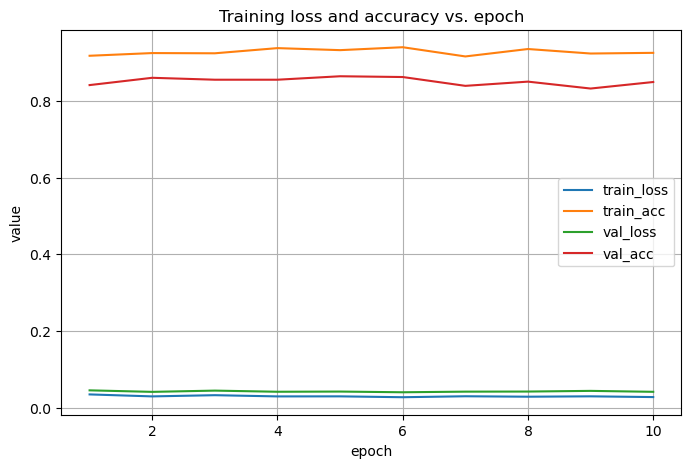

In [8]:
import matplotlib.pyplot as plt

# 绘制 train_loss 和 train_acc 随 epoch 变化的曲线
epochs = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["train_acc"], label="train_acc")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.plot(epochs, history["val_acc"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("value")
plt.title("Training loss and accuracy vs. epoch")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# 实验不同的 learning_rate
learning_rates = [0.0001, 0.001]
for lr in learning_rates:
    clf = MultiClassPerceptron(
        digit_classes, learning_rate=lr, epochs=10, init_scale=0.01
    )
    clf.train(X_train, y_train)
    loss, acc = clf.evaluate(X_test, y_test)
    print(f"[SquaredLoss] learning_rate={lr} test_loss={loss:.4f} test_acc={acc:.4f}")

[SquaredLoss] learning_rate=0.0001 test_loss=0.0377 test_acc=0.8650
[SquaredLoss] learning_rate=0.001 test_loss=0.0424 test_acc=0.8510


In [ ]:
# 实验不同的 scale（合理范围建议：0.001~0.1，过大易导致训练不收敛）# 实验不同的 scale（合理范围建议：0.001~0.1，过大易导致训练不收敛）
init_scales = [0.001, 0.005, 0.01, 0.05]
for scale in init_scales:
    clf = MultiClassPerceptron(
        digit_classes=10, learning_rate=0.001, epochs=20, init_scale=scale
    )
    clf.train(X_train, y_train)
    loss, acc = clf.evaluate(X_test, y_test)
    print(f"[SquaredLoss] weight_init={scale} test_loss={loss:.4f} test_acc={acc:.4f}")

[SquaredLoss] weight_init=0.001 test_loss=0.0434 test_acc=0.8420
[SquaredLoss] weight_init=0.005 test_loss=0.0411 test_acc=0.8520
[SquaredLoss] weight_init=0.01 test_loss=0.0458 test_acc=0.8360
[SquaredLoss] weight_init=0.05 test_loss=0.0481 test_acc=0.8150
